# This tutorial has two parts: one for NLP with earpod data, the other for survival analysis with startup company data. 

# 1. NLP with playstation data

In [5]:
# Import dependencies
# DO NOT MODIFY THIS CELL
import pandas as pd
import gzip
import numpy as np 

import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from collections import Counter

from wordcloud import STOPWORDS 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Load necessary datasets
# DO NOT MODIFY THIS CELL

# Load the dataset with reviews from the server
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games.json.gz

--2022-11-29 08:28:09--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 386419180 (369M) [application/x-gzip]
Saving to: ‘reviews_Video_Games.json.gz.1’

reviews_Video_Games 100%[===================>] 368.52M  18.4MB/s    in 25s     

2022-11-29 08:28:34 (14.5 MB/s) - ‘reviews_Video_Games.json.gz.1’ saved [386419180/386419180]



In [7]:
# Some helper functions

# Functions to process file with reviews 
# DO NOT MODIFY THIS CELL

# Parse all the parts of the review file
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

# Read json to dictionary and turn it into the Data Frame
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

# Create functions to clean the text
# DO NOT MODIFY THIS CELL

# Function to clean text
def clean_text(Review):   
  Review = str(Review).lower() # convert to lowercase
  Review = re.sub('\[.*?\]', '', Review)  # Remove special symbols
  Review = re.sub('https?://\S+|www\.\S+', '', Review) # Remove URls
  Review = re.sub('<.*?>+', '', Review) # Remove special symbols
  Review = re.sub(r'[^a-z0-9\s]', '', Review) # Remove punctuation
  Review = re.sub('\n', '', Review) # Remove forced enter
  Review = re.sub('\w*\d\w*', '', Review) # Remove metacharachters
  return Review
  
# Function to convert list to string 
def listToString(s):
   
  # initialize an empty string
  str1 = " "
  
    
  # return string 
  return (str1.join(s))

# Function to remove stopwords
def remove_stopword(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

In [10]:
# Fix the selected product asin (Amazon Standart Identification Number)
product = "B00BGA9WK2" # PlayStation 4
# Create DataFrame from JSON-file with reviews
df = getDF("reviews_Video_Games.json.gz")
# Create DataFrame from JSON-file with meta data
#df_meta = getDF('meta_Cell_Phones_and_Accessories.json.gz')
# See the meta description of the product
#df_meta.loc[df_meta['asin'].isin([product])]

# Create product-related data frame 
df_playstation = df[df.asin.isin([product])]
# Leave only review text and rating
df_playstation_text = df_playstation[['reviewText','overall']].reset_index(drop=True)
# Create column "Sentiment" for sentiment values (0 - negative, 1 - positive). Sentiment is positive if "overall" rating value is >= 4.0
df_playstation_text["Sentiment"] = df_playstation_text['overall'].apply(lambda x: 1 if (x >=4.0) else 0)

# Load standard list of stopwords
stop_words = set(STOPWORDS)
stop_words.update(['system', 'game', 'sony', 'console'])

# Clean review texts and delete frequent meaningless words
df_playstation_text['review'] = df_playstation_text['reviewText'].apply(clean_text)
df_playstation_text['review'] = df_playstation_text['review'].apply(lambda row: remove_stopword(stop_words, row)).apply(lambda row: listToString(row))


## Build a classifier with keras

In [42]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re

In [43]:
# Create vectors for features and labels
review_text = df_playstation_text['review']
sent_label = df_playstation_text['Sentiment']

In [44]:
# split to train and test
X_train, X_test, y_train, y_test \
= train_test_split(review_text, sent_label,random_state = 42,test_size = 0.20)

In [45]:
X_train.shape

(6048,)

In [58]:
# split to train and val
train_text, val_text, train_label, val_label \
= train_test_split(X_train, y_train,random_state = 42,test_size = 0.20)
test_text = X_test
test_label = y_test

(4838,)

In [59]:
MAX_FEATURES = 5000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_text)
train_text = tokenizer.texts_to_sequences(train_text)
val_text = tokenizer.texts_to_sequences(val_text)
test_text = tokenizer.texts_to_sequences(test_text)
vocab_size = len(tokenizer.word_index) + 1 

In [87]:
MAX_LENGTH = max(len(train_ex) for train_ex in train_text) 
train_text = pad_sequences(train_text, maxlen=MAX_LENGTH,padding='post')
val_text = pad_sequences(val_text, maxlen=MAX_LENGTH,padding='post')
test_text = pad_sequences(test_text, maxlen=MAX_LENGTH,padding='post')
#print(train_text[0, :])
MAX_LENGTH

1165

In [89]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = 200, input_length=MAX_LENGTH, trainable=False),
    tf.keras.layers.Conv1D(128, 5, activation='relu', input_shape = (MAX_LENGTH,1)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
    
model.summary()
model.compile(
     optimizer='rmsprop',
     loss='binary_crossentropy',
     metrics=['binary_accuracy'])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 1165, 200)         3381800   
                                                                 
 conv1d_4 (Conv1D)           (None, 1161, 128)         128128    
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,511,229
Trainable params: 3,511,229
Non-trainable params: 0
___________________________________________

In [90]:
%%time
history = model.fit(
    train_text, 
    train_label, 
    batch_size=128,
    epochs=10, 
    validation_data=(val_text, val_label),)

Epoch 1/10
38/38 [==============================] - 67s 2s/step - loss: 0.6872 - binary_accuracy: 0.7439 - val_loss: 0.6681 - val_binary_accuracy: 0.8471
Epoch 2/10
38/38 [==============================] - 67s 2s/step - loss: 0.6436 - binary_accuracy: 0.8615 - val_loss: 0.6186 - val_binary_accuracy: 0.8793
Epoch 3/10
38/38 [==============================] - 66s 2s/step - loss: 0.5859 - binary_accuracy: 0.9072 - val_loss: 0.5919 - val_binary_accuracy: 0.8876
Epoch 4/10
38/38 [==============================] - 67s 2s/step - loss: 0.5433 - binary_accuracy: 0.9368 - val_loss: 0.5849 - val_binary_accuracy: 0.8826
Epoch 5/10
38/38 [==============================] - 66s 2s/step - loss: 0.5110 - binary_accuracy: 0.9545 - val_loss: 0.5764 - val_binary_accuracy: 0.8909
Epoch 6/10
38/38 [==============================] - 66s 2s/step - loss: 0.4872 - binary_accuracy: 0.9653 - val_loss: 0.5780 - val_binary_accuracy: 0.8917
Epoch 7/10
38/38 [==============================] - 66s 2s/step - loss: 0.46

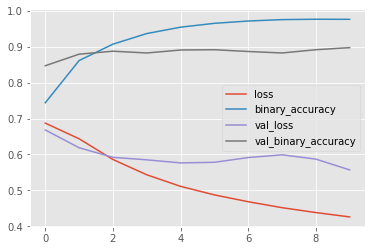

In [91]:
pd.DataFrame(history.history).plot(figsize=(6,4))
plt.grid(True)
plt.show()

In [94]:
preds = model.predict(test_text)
print('Accuracy score: {:0.4}'.format(accuracy_score(test_label, 1 * (preds > 0.5))))
print('F1 score: {:0.4}'.format(f1_score(test_label, 1 * (preds > 0.5))))
print('ROC AUC score: {:0.4}'.format(roc_auc_score(test_label, preds)))

48/48 [==============================] - 6s 119ms/step
Accuracy score: 0.8883
F1 score: 0.9258
ROC AUC score: 0.9087
